In [1]:
import os
import sys
import time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(0)

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt

2023-06-18 09:58:19.262578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 09:58:19.442743: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-18 09:58:20.281298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-18 09:58:20.281412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic

In [2]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [3]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [4]:
from test_utility import *

# Start Test

In [5]:
n_times = 1000; n_markets = 100; n_fields = 10
Candles = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
Candles = np.array(Candles, dtype=np.float32)
Times = np.array( range(Candles.shape[0]), dtype=Candles.dtype ) + 333
Times = np.expand_dims(Times, axis=1)
size_time = 1
print(Candles.shape, Times.shape)   # time, market, field
print(Candles[:2, :, :])

(1000, 100, 10) (1000, 1)
[[[0.000e+00 1.000e+00 2.000e+00 ... 7.000e+00 8.000e+00 9.000e+00]
  [1.000e+01 1.100e+01 1.200e+01 ... 1.700e+01 1.800e+01 1.900e+01]
  [2.000e+01 2.100e+01 2.200e+01 ... 2.700e+01 2.800e+01 2.900e+01]
  ...
  [9.700e+02 9.710e+02 9.720e+02 ... 9.770e+02 9.780e+02 9.790e+02]
  [9.800e+02 9.810e+02 9.820e+02 ... 9.870e+02 9.880e+02 9.890e+02]
  [9.900e+02 9.910e+02 9.920e+02 ... 9.970e+02 9.980e+02 9.990e+02]]

 [[1.000e+03 1.001e+03 1.002e+03 ... 1.007e+03 1.008e+03 1.009e+03]
  [1.010e+03 1.011e+03 1.012e+03 ... 1.017e+03 1.018e+03 1.019e+03]
  [1.020e+03 1.021e+03 1.022e+03 ... 1.027e+03 1.028e+03 1.029e+03]
  ...
  [1.970e+03 1.971e+03 1.972e+03 ... 1.977e+03 1.978e+03 1.979e+03]
  [1.980e+03 1.981e+03 1.982e+03 ... 1.987e+03 1.988e+03 1.989e+03]
  [1.990e+03 1.991e+03 1.992e+03 ... 1.997e+03 1.998e+03 1.999e+03]]]


In [6]:
Nx = 10
Ny = 2
Ns = 10

sample_anchors = np.array(range(0, Candles.shape[0] - Nx - Ny + 1, Ns), dtype=np.int32)
sample_anchores_t = sample_anchors[: sample_anchors.shape[0] * 3 // 4]
sample_anchores_v = sample_anchors[sample_anchors.shape[0] * 3 // 4 :]
print(Candles.shape, sample_anchors.shape, sample_anchores_t.shape, sample_anchores_v.shape)

x_indices = ( (0, 1, 2), (0,1,2) )    # (market, field)
y_indices = ( (2, 3, 4), (1,2,3) )    # (market, field). Currently must be the same size as x_indices.
print(Candles[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(Candles[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)

print(size_x, size_y, size_time)

(1000, 100, 10) (99,) (74,) (25,)
[[[0.000e+00 1.000e+00 2.000e+00]
  [1.000e+01 1.100e+01 1.200e+01]
  [2.000e+01 2.100e+01 2.200e+01]]

 [[1.000e+03 1.001e+03 1.002e+03]
  [1.010e+03 1.011e+03 1.012e+03]
  [1.020e+03 1.021e+03 1.022e+03]]]
[[[2021. 2022. 2023.]
  [2031. 2032. 2033.]
  [2041. 2042. 2043.]]

 [[3021. 3022. 3023.]
  [3031. 3032. 3033.]
  [3041. 3042. 3043.]]]
9 9 1


In [7]:
# Dummy variables
CandleMarks = Candles[:, :, 0]
all_market_names = [ 'market_' + str(i) for i in range(Candles.shape[1])]
all_field_names = [ 'filed_' + str(i) for i in range(Candles.shape[2])]
min_true_candle_percent_x = 50
chosen_fields_names_x = all_field_names[2:7]
min_true_candle_percent_y = 50
chosen_fields_names_y = all_field_names[0:5]
target_market_names = all_market_names[2:15] #[0:1] # [1:2]
tarket_market_top_percent = 15

assert min_true_candle_percent_x == min_true_candle_percent_y
assert len(chosen_fields_names_x) == len(chosen_fields_names_y)

Candles, CandleMarks, all_market_names, x_indices, y_indices, \
chosen_market_names_x, chosen_field_names_x, chosen_market_names_y, chosen_field_names_y, \
chosen_market_names, chosen_field_names, \
target_markets_names, target_markets = \
get_formed_data( Candles, CandleMarks, all_market_names, all_field_names, 
        min_true_candle_percent_x, chosen_fields_names_x, min_true_candle_percent_y, chosen_fields_names_y,
        target_market_names, tarket_market_top_percent
)

print(Candles.shape)
print(CandleMarks.shape)
print(len(all_market_names))
print(x_indices)
print(y_indices)
print(chosen_market_names_x)
print(chosen_field_names_x)
print(chosen_market_names_y)
print(chosen_field_names_y)
print(chosen_market_names)
print(chosen_field_names)
print(target_markets_names)
print(target_markets)
print(len(chosen_market_names_x), len(chosen_market_names_y), len(target_markets_names))

(1000, 100, 7)
(1000, 100)
100
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99), (2, 3, 4, 5, 6))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99), (0, 1, 2, 3, 4))
['market_49', 'market_72', 'market_71', 'market_70', 'market_69', 'market_68', 'market_67', 'market_66', 'market_65', 'market_64', 'market_63', 'mark

In [8]:
Time_into_X = True
Time_into_Y = False
BatchSize = 2
shuffle_batch = 10

ds_train, ds_valid, dx, dy = \
get_datasets_2(
    Candles, Time_into_X, Time_into_Y, Times, 
    sample_anchores_t, sample_anchores_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets,
    BatchSize, shuffle_batch, shuffle=True
)

print(len(ds_train), len(ds_valid))

2023-06-18 09:58:25.132105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 09:58:25.919537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38237 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


37 13


In [9]:
non_target_markets_relative = [ y_indices[0].index(i) for i in y_indices[0] if i not in target_markets ]
print(non_target_markets_relative)
nFeaturesPerMarket = len(y_indices[1])
print(nFeaturesPerMarket)
all_ntmr = []
for ntmr in non_target_markets_relative:
    all_ntmr = all_ntmr + list(range(ntmr* nFeaturesPerMarket, (ntmr+1) * nFeaturesPerMarket, 1))
non_target_features_relative = tuple(all_ntmr)
print(non_target_features_relative)

def anchor_to_sample(anchor): # This function is the bottle-neck of training speed.
    x = np.reshape(Candles[anchor: anchor + Nx][:, x_indices[0]][:, :, x_indices[1]], (Nx, -1))
    if Time_into_X is True:
        assert Times is not None
        x = np.concatenate((x, np.reshape(Times[anchor: anchor + Nx], (Nx, -1))), axis=1) # concat(x, x_time)

    y = np.reshape(Candles[anchor + Nx: anchor + Nx + Ny][:, y_indices[0]][:, :, y_indices[1]], (Ny, -1))

    if Time_into_X is True:
        assert Times is not None
        y_time = np.reshape(Times[anchor + Nx: anchor + Nx + Ny], (Ny, -1))
        if Time_into_Y is not True: y_time[:] = 0.0
        y = np.concatenate((y, y_time), axis=1)

    x = np.pad(x, [[1,1], [0,0]], constant_values=0)   # (1 pre-pad: Start, 1 post-pad: End) on axis 0. (0 pre-pad, 0 post-pad) on axis 1.
    y = np.pad(y, [[1,1], [0,0]], constant_values=0)

    if x.shape[-1] % 2 != 0:
        x = np.pad(x, [[0,0], [0,1]], constant_values=0) # (0 pre-pad: Start, 0 post-pad: End) on axis 0. (0 pre-pad, 1 post-pad) on axis 1.
        y = np.pad(y, [[0,0], [0,1]], constant_values=0)

    y[:, non_target_features_relative] = 0.0 # Start/Stop = NoInfo = 0.0

    return x, y[:-1], y[1:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
5
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153

In [10]:
anchor = 10

x, y, y_shift = anchor_to_sample(anchor)
print(x.shape)
print(y.shape)
print(y_shift.shape)

(12, 502)
(3, 502)
(3, 502)


In [11]:
print(Candles[:4, :, :]) # market order may be changed by argmax.

[[[4.900e+02 4.910e+02 4.920e+02 ... 4.940e+02 4.950e+02 4.960e+02]
  [7.200e+02 7.210e+02 7.220e+02 ... 7.240e+02 7.250e+02 7.260e+02]
  [7.100e+02 7.110e+02 7.120e+02 ... 7.140e+02 7.150e+02 7.160e+02]
  ...
  [2.600e+02 2.610e+02 2.620e+02 ... 2.640e+02 2.650e+02 2.660e+02]
  [3.600e+02 3.610e+02 3.620e+02 ... 3.640e+02 3.650e+02 3.660e+02]
  [0.000e+00 1.000e+00 2.000e+00 ... 4.000e+00 5.000e+00 6.000e+00]]

 [[1.490e+03 1.491e+03 1.492e+03 ... 1.494e+03 1.495e+03 1.496e+03]
  [1.720e+03 1.721e+03 1.722e+03 ... 1.724e+03 1.725e+03 1.726e+03]
  [1.710e+03 1.711e+03 1.712e+03 ... 1.714e+03 1.715e+03 1.716e+03]
  ...
  [1.260e+03 1.261e+03 1.262e+03 ... 1.264e+03 1.265e+03 1.266e+03]
  [1.360e+03 1.361e+03 1.362e+03 ... 1.364e+03 1.365e+03 1.366e+03]
  [1.000e+03 1.001e+03 1.002e+03 ... 1.004e+03 1.005e+03 1.006e+03]]

 [[2.490e+03 2.491e+03 2.492e+03 ... 2.494e+03 2.495e+03 2.496e+03]
  [2.720e+03 2.721e+03 2.722e+03 ... 2.724e+03 2.725e+03 2.726e+03]
  [2.710e+03 2.711e+03 2.712e+03

In [12]:
# Complete check of x

for anchor in np.concatenate((sample_anchores_t, sample_anchores_v)):

    x, y, y_shift = anchor_to_sample(anchor)

    assert x.shape[0] == Nx + 2
    size_x = len(chosen_market_names_x)  * len(chosen_field_names_x)
    odd_padding = (1 if size_x // 2 != 0 else 0)
    assert x.shape[1] == size_x + size_time + odd_padding

    seq = 0
    assert np.sum(x[seq]>0) == 0

    for seq in range(1, x.shape[0]-1):
        for i in range(x.shape[1] - size_time - odd_padding):
            assert x[seq][i] == Candles[anchor + seq - 1, x_indices[0] [i//len(chosen_field_names_x)], x_indices[1] [(i%len(chosen_field_names_x))]]

        if odd_padding > 0:
            assert x[seq][-1] == 0.0     # -1 for the odd-padding
        for i in range(size_time):
            assert x[seq][- size_time - odd_padding + i ] == Times[anchor + seq - 1][i]

    seq = x.shape[0] - 1
    assert np.sum(x[seq]>0) == 0

In [13]:
# Complete check of y

for anchor in np.concatenate((sample_anchores_t, sample_anchores_v)):

    x, y, y_shift = anchor_to_sample(anchor)

    assert y.shape[0] == Ny + 1
    assert y.shape[1] == x.shape[1]

    seq = 0
    assert np.sum(x[seq]>0) == 0

    for seq in range(1, y.shape[0]):
        for i in range(y.shape[1] - size_time - odd_padding):
            if i//len(chosen_field_names_y) in target_markets:
                assert y[seq][i] == Candles[anchor + Nx + seq - 1, y_indices[0] [i//len(chosen_field_names_y)], y_indices[1] [(i%len(chosen_field_names_y))]]
            else:
                assert y[seq][i] == 0.0

In [14]:
# Complete check of y_shift

for anchor in np.concatenate((sample_anchores_t, sample_anchores_v)):

    x, y, y_shift = anchor_to_sample(anchor)

    assert y_shift.shape[0] == Ny + 1
    assert y_shift.shape[1] == x.shape[1]

    for seq in range(0, y_shift.shape[0]-1):
        for i in range(y_shift.shape[1] - size_time - odd_padding):
            if i//len(chosen_field_names_y) in target_markets:
                assert y_shift[seq][i] == Candles[anchor + Nx + seq, y_indices[0] [i//len(chosen_field_names_y)], y_indices[1] [(i%len(chosen_field_names_y))]]
            else:
                assert y_shift[seq][i] == 0.0

    seq = y_shift.shape[0] - 1
    assert np.sum(y_shift[seq]>0) == 0

In [15]:
ds_train, ds_valid, dx, dy = \
get_datasets_2(
    Candles, Time_into_X, Time_into_Y, Times, 
    sample_anchores_t, sample_anchores_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets,
    BatchSize, shuffle_batch, shuffle=True
)

In [16]:
for elem in ds_train:
    print(elem)
    break

((<tf.Tensor: shape=(2, 12, 502), dtype=float32, numpy=
array([[[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [ 60492.,  60493.,  60494., ...,  60006.,      0.,      0.],
        [ 61492.,  61493.,  61494., ...,  61006.,      0.,      0.],
        ...,
        [ 68492.,  68493.,  68494., ...,  68006.,    401.,      0.],
        [ 69492.,  69493.,  69494., ...,  69006.,    402.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]],

       [[     0.,      0.,      0., ...,      0.,      0.,      0.],
        [150492., 150493., 150494., ..., 150006.,      0.,      0.],
        [151492., 151493., 151494., ..., 151006.,      0.,      0.],
        ...,
        [158492., 158493., 158494., ..., 158006.,    491.,      0.],
        [159492., 159493., 159494., ..., 159006.,    492.,      0.],
        [     0.,      0.,      0., ...,      0.,      0.,      0.]]],
      dtype=float32)>, <tf.Tensor: shape=(2, 3, 502), dtype=float32, numpy=
array([[[0

2023-06-18 09:58:29.009835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# End Test

In [17]:
import ipyparams
notebookName = ipyparams.notebook_name  # This only works on browser.
data_model = "vm07.05.300.11.90.eth.8.1"

dir_data = "/mnt/data/Trading/"

#===================================================================== Dataset

Nx = 300 # ------------- test
Ny = 11
Ns = 5 #--------------------- test
BatchSize = 64

Shift = 3 # past: 2

CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
SmallSigma = 1
LargeSigma = 30
eFreeNoLog = True

shuffle_batch = 100  # Keep it small to speed up model loading.

dir_candles = os.path.join(dir_data, "Candles")

min_true_candle_percent_x = 90
chosen_markets_x = []
chosen_fields_names_x = ['ClosePrice'] #, 'BaseVolume']
min_true_candle_percent_y = 90
assert min_true_candle_percent_x == min_true_candle_percent_y
chosen_markets_y = []
chosen_fields_names_y = ['ClosePrice']

target_market_names = None
# target_market_names = ['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT']
target_market_names = ['ETHUSDT']
tarket_market_top_percent = 15

Standardization = True
Kill_Irregulars = True  # ----------------- pls implement it
Time_into_X = True
Time_into_Y = False #
eFreeNoPlot = True

#======================================================================== Model

Num_Layers = 8 # Wow
Num_Heads = 1   # As we have a single GPU, and we want to a exhaustic attention.
Factor_FF = 4
repComplexity = 8  # Wower
Dropout_Rate = 0.1

dir_Checkpoint = os.path.join(dir_data, "Checkpoints")
checkpoint_filepath = os.path.join(dir_Checkpoint, data_model)
dir_CSVLogs = os.path.join(dir_data, "CSVLogs")
csvLogger_filepath = os.path.join(dir_CSVLogs, data_model)

#======================================================================== Train

Epochs_Initial = 5000
HuberThreshold = 1.0
Checkpoint_Monitor = "val_loss"
EarlyStopping_Min_Monitor = "val_loss"
EarlyStopping_Patience = 30

Optimizer = "adam"
Learning_Rate = 0.0001  # default: 0.001

#=============================================================== Checksum

assert int(data_model.split('.')[1]) == int(CandleFile.split('-')[-1][:-1])
assert int(data_model.split('.')[2]) == Nx
assert int(data_model.split('.')[3]) == Ny
assert int(data_model.split('.')[4]) == min_true_candle_percent_x
assert int(data_model.split('.')[6]) == Num_Layers
targets = data_model.split('.')[5]
if targets.isnumeric():
    assert target_market_names is None
    assert int(targets) == tarket_market_top_percent
else:
    for target in targets.split(','):
        assert (target+'usdt').upper() in target_market_names

<IPython.core.display.Javascript object>

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_virtual_device_configuration(
            #     gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]) # why 5120?
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

mirrored_strategy = None
if len(gpus) > 1: 
    mirrored_strategy = tf.distribute.MirroredStrategy()
    Learning_Rate = Learning_Rate * len(gpus) * 3 / 4

# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


In [19]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
import json

In [20]:
def upgrade_file(path):
    with open(path, "+tw") as f:
        f.write("# Sorry, the content is removed.")
        f.write("\n# Please ask Mike for the content.")

In [21]:
folders = [dir_data, dir_candles, dir_Checkpoint, dir_CSVLogs]
for folder in folders:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [22]:
#==================== Load candle data into 'table' with shape of (time, markets, 10 fields) ====================
Candles = np.load( os.path.join( dir_candles, "table-" + CandleFile + ".npy") )
Candles = np.swapaxes(Candles, 0, 1)
Candles = Candles.astype(np.float32)    # Ugly, just confirm.
print("Candles: {}".format(Candles.shape))

Candles: (565633, 336, 10)


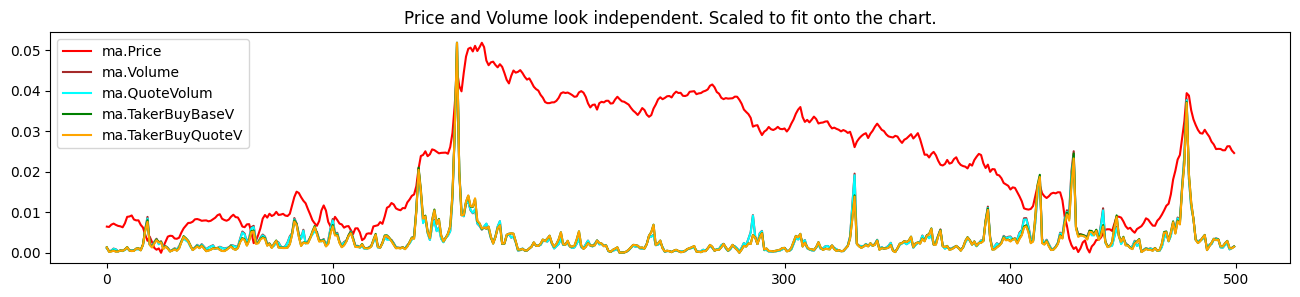

In [23]:
market = 5
Show_Price_Volume_10(Candles[:, market, :], 1, 1, 500)

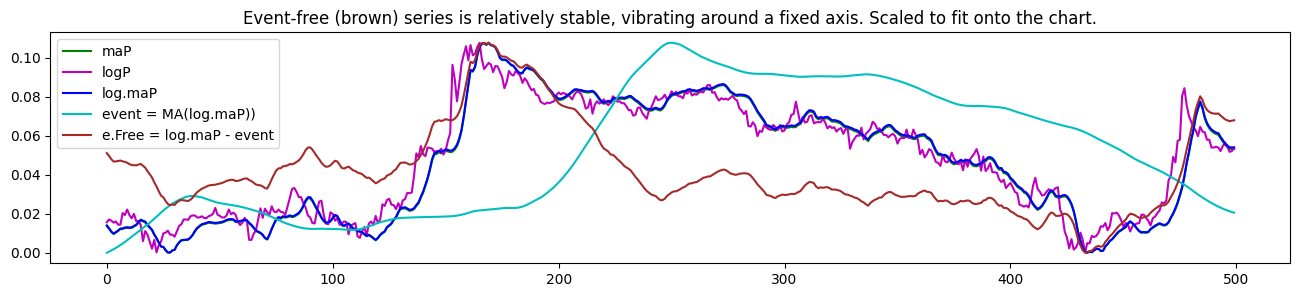

In [24]:
Event_Free_Learning_Scheme_10(Candles[:, market, :], 3, 30, 500)

In [25]:
#==================== Delete 7 candle fields from 'Candles'. ====================
# Candles.shape becomes (time, markets, ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume'] )

CandleMarks = Candles[:, :, 9] # keep it for later use
Candles = np.delete(Candles, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, CandleMarks
all_field_names = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

assert (~np.isfinite(Candles)).any() == False

table_markets = []
with open( os.path.join( dir_candles, "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

all_market_names = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert Candles.shape[1] == len(all_market_names)
print(Candles.shape, len(all_market_names), all_market_names[:2])

['ALICEUSDT: 565633, 336924 created. Success. 1-th.', 'DOTUSDT: 565633, 277039 created. Success. 2-th.']
(565633, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [26]:
Candles, CandleMarks, all_market_names, x_indices, y_indices, \
chosen_market_names_x, chosen_field_names_x, chosen_market_names_y, chosen_field_names_y, \
chosen_market_names, chosen_field_names, \
target_markets_names, target_markets = \
get_formed_data( Candles, CandleMarks, all_market_names, all_field_names, 
        min_true_candle_percent_x, chosen_fields_names_x, min_true_candle_percent_y, chosen_fields_names_y,
        target_market_names, tarket_market_top_percent
)

print(Candles.shape)
print(CandleMarks.shape)
print(len(all_market_names))
print(x_indices)
print(y_indices)
print(chosen_market_names_x)
print(chosen_field_names_x)
print(chosen_market_names_y)
print(chosen_field_names_y)
print(chosen_market_names)
print(chosen_field_names)
print(target_markets_names)
print(target_markets)
print(len(chosen_market_names_x), len(chosen_market_names_y), len(target_markets_names))

(565633, 17, 1)
(565633, 17)
336
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), (0,))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), (0,))
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT']
['ClosePrice']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT']
['ClosePrice']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT']
['ClosePrice']
['ETHUSDT']
(3,)
17 17 1


In [27]:
start_ts, interval_s, timestamps_abs = get_timestamps_2(CandleFile, Candles.shape[0])
print(start_ts, interval_s, timestamps_abs.shape, timestamps_abs[:3])

Times = get_time_features(timestamps_abs)
Times = Times.astype(Candles.dtype)
size_time = Times.shape[1]

assert Candles.shape[0] == Times.shape[0]
print(Candles.shape, Times.shape)

1514764800 300 (565633,) [1514764800 1514765100 1514765400]
(565633, 17, 1) (565633, 4)


In [28]:
#==================== Generate event-free data into Data ====================
# Data loses heading items.
# Do it before: Permute Data in time

alpha = 3; beta = 3 # beta is used in 'get_eFree_with_plot'. Ugly coupling.
event_free_data_loss = 3 * ( alpha * SmallSigma + LargeSigma)
eFree = np.zeros( (Candles.shape[0] - event_free_data_loss, len(chosen_market_names), len(chosen_field_names)), dtype = Candles.dtype )

for market in range(Candles.shape[1]):
    for field in range(Candles.shape[2]):
        sSigma = SmallSigma
        if all_field_names[field] == 'BaseVolume': sSigma = SmallSigma * alpha
        P, maP, logP, log_maP, event, eventFree = \
        get_eFree_with_plot(all_market_names[market], all_field_names[field], Candles[:, market, field], sSigma,
                            LargeSigma, Candles.shape[0] - event_free_data_loss, noPlot=eFreeNoPlot, noLog=eFreeNoLog)
        assert Candles.shape[0] - event_free_data_loss == eventFree.shape[0]
        eventFree = eventFree.astype(Candles.dtype)
        Candles[event_free_data_loss:, market, field] = eventFree

Candles = Candles[event_free_data_loss + Shift:]
Times = Times[event_free_data_loss + Shift:]
assert Candles.shape[0] == Times.shape[0]

print(Candles.shape, Times.shape)

(565531, 17, 1) (565531, 4)


In [29]:
Standard = None

if Standardization:
    Candles, Standard = standardize_2(Candles)

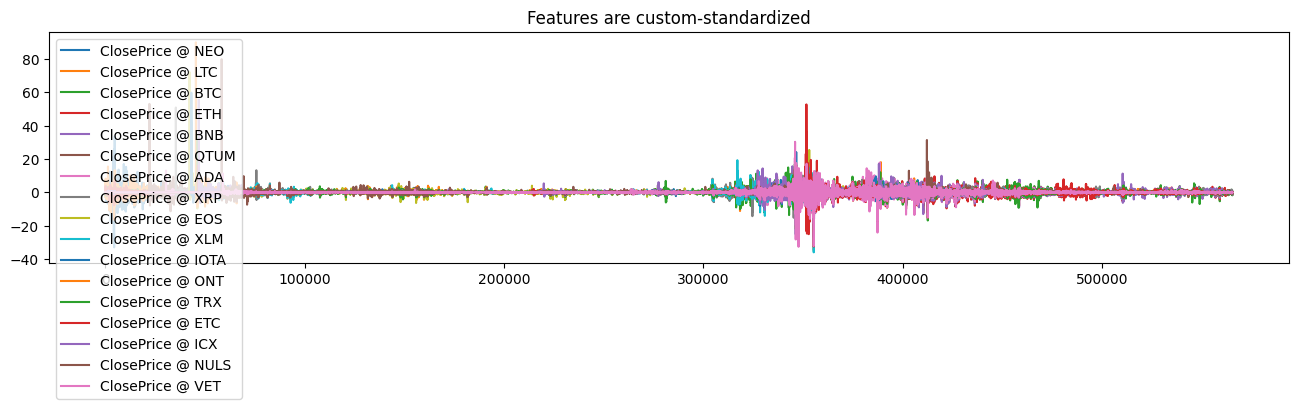

In [30]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized" if Standardization else "Features are not standardized")
for market in range(Candles.shape[1]):
    for field in range(Candles.shape[2]):
        ax.plot(Candles[:, market, field], label = "{} @ {}".format(all_field_names[field], all_market_names[market][:-len('USDT')]))
ax.legend(loc = 'upper left')
plt.show()

In [31]:
sample_anchores_t, sample_anchores_v = get_sample_anchors_2(Candles, Nx, Ny, Ns)
print(sample_anchores_t.shape, sample_anchores_v.shape)

(79131,) (33914,)


In [32]:
ds_train, ds_valid, dx, dy = \
get_datasets_2(
    Candles, Time_into_X, Time_into_Y, Times, 
    sample_anchores_t, sample_anchores_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets,
    BatchSize, shuffle_batch, shuffle=(len(gpus)<=1)
)

In [33]:
train = ds_train.take(1)
print(train)

<TakeDataset element_spec=((TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>


In [34]:
model = None

if mirrored_strategy is None:
    model = build_model_2(
        dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
        HuberThreshold, Optimizer, Learning_Rate
    )
else:
    with mirrored_strategy.scope():
        model = build_model_2(
            dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
            HuberThreshold, Optimizer, Learning_Rate
        )

In [35]:
callbacks = get_callbacks(
    checkpoint_filepath, Checkpoint_Monitor, 
    csvLogger_filepath, 
    EarlyStopping_Min_Monitor, EarlyStopping_Patience
)

try:
    model.load_weights(checkpoint_filepath)
    print("Loading a checkpoint...")
except:
    print("No checkpoint to load")
    pass

try:
    columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
    plot_csv_train_history(csvLogger_filepath, columns, title=data_model)
except:
    pass

Loading a checkpoint...


In [36]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=1, #Epochs_Initial,
    callbacks=callbacks
)

2023-06-18 09:59:20.672110: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/1237 [..............................] - ETA: 10:54:57 - loss: 0.0081 - mTA: 0.6125

2023-06-18 09:59:21.466867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1055/1237 [========================>.....] - ETA: 16s - loss: 0.0063 - mTA: 0.5818

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=20, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=50, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=500, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=500, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=500, #Epochs_Initial,
    callbacks=callbacks
)

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)